# タイタニックの乗客データを使った生存者推定モデルの生成2
参照: [PyData.Tokyo Tutorial & Hackathon #1](https://github.com/PyDataTokyo/pydata-tokyo-tutorial-1/blob/master/pydatatokyo_tutorial_ml.ipynb)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# from sklearn.grid_search import GridSearchCV
from IPython.display import Image

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold

# Pandasの設定をします
pd.set_option('chained_assignment', None)

# matplotlibのスタイルを指定します。これでグラフが少しかっこよくなります。
plt.style.use('ggplot')
plt.rc('xtick.major', size=0)
plt.rc('ytick.major', size=0)

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [5]:
df_test .tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## 3. ジェンダーモデルによる生存者推定、推定値の評価

In [6]:
x = df_train['Sex']
y = df_train['Survived']

In [7]:
y_pred = x.map({'female': 1, 'male': 0}).astype(int)

In [8]:
print('Accuracy: {:.3f}'.format(accuracy_score(y, y_pred)))

Accuracy: 0.787


In [9]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.85      0.83       549
          1       0.74      0.68      0.71       342

avg / total       0.78      0.79      0.78       891



In [10]:
cm = confusion_matrix(y, y_pred)
print(cm)

[[468  81]
 [109 233]]


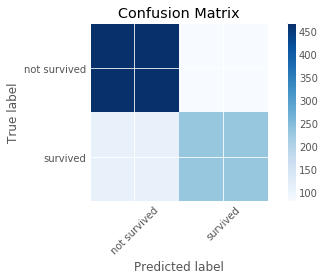

In [11]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix')
    fig.colorbar(im)

    target_names = ['not survived', 'survived']

    tick_marks = np.arange(len(target_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(target_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(target_names)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    fig.tight_layout()

plot_confusion_matrix(cm)


### テストデータから生存者を推定

#### 演習問題
トレーニングデータと同様に、Kaggleに投稿するテストデータからも生存者を推定しましょう。

In [12]:
x_test = df_test['Sex']
y_test_pred = x_test.map({'female': 1, 'male': 0}).astype(int)

In [13]:
df_kaggle = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived':np.array(y_test_pred)})
df_kaggle.to_csv('kaggle_gendermodel.csv', index=False)

In [14]:
df_kaggle.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 4. ロジスティック回帰による生存者推定

In [15]:
X = df_train[['Age', 'Pclass', 'Sex']]
y = df_train['Survived']

In [16]:
X.tail()

,Age,Pclass,Sex
886,27.0,2,male
887,19.0,1,female
888,NaN,3,female
889,26.0,1,male
890,32.0,3,male


In [17]:
X['AgeFill'] = X['Age'].fillna(X['Age'].mean())
X = X.drop(['Age'], axis=1)
X['Gender'] = X['Sex'].map({'female': 0, 'male': 1}).astype(int)

In [18]:
X.tail()

,Pclass,Sex,AgeFill,Gender
886,2,male,27.000000,1
887,1,female,19.000000,0
888,3,female,29.699118,0
889,1,male,26.000000,1
890,3,male,32.000000,1


In [19]:
X['Pclass_Gender'] = X['Pclass'] + X['Gender']

In [20]:
X.tail()

,Pclass,Sex,AgeFill,Gender,Pclass_Gender
886,2,male,27.000000,1,3
887,1,female,19.000000,0,1
888,3,female,29.699118,0,3
889,1,male,26.000000,1,2
890,3,male,32.000000,1,4


In [21]:
X = X.drop(['Pclass', 'Sex', 'Gender'], axis=1)

In [22]:
X.head()

,AgeFill,Pclass_Gender
0,22.0,4
1,38.0,1
2,26.0,3
3,35.0,1
4,35.0,4


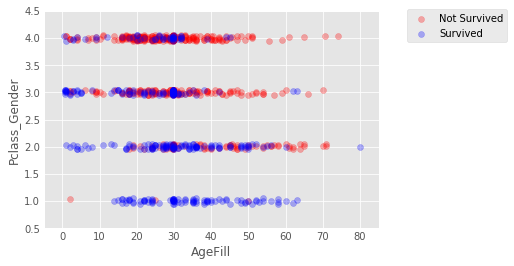

In [23]:
np.random.seed = 0

xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5

index_survived = y[y==0].index
index_notsurvived = y[y==1].index

fig, ax = plt.subplots()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
sc = ax.scatter(X.loc[index_survived, 'AgeFill'],
                X.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(X.loc[index_notsurvived, 'AgeFill'],
                X.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(bbox_to_anchor=(1.4, 1.03))
plt.show()

#### トレーニングデータの分割

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

In [25]:
X_train

,AgeFill,Pclass_Gender
301,29.699118,4
309,30.000000,1
516,34.000000,2
120,21.000000,3
570,62.000000,3
730,29.000000,1
228,18.000000,3
563,29.699118,4
311,18.000000,1
613,29.699118,4


In [26]:
print('Num of Training Samples: {}'.format(len(X_train)))
print('Num of Validation Samples: {}'.format(len(X_val)))

Num of Training Samples: 712
Num of Validation Samples: 179


In [27]:
clf = LogisticRegression()

In [28]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

In [30]:
print('Accuracy on Training Set: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Accuracy on Validation Set: {:.3f}'.format(accuracy_score(y_val, y_val_pred)))

Accuracy on Training Set: 0.774
Accuracy on Validation Set: 0.760


In [31]:
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

[[93 13]
 [30 43]]


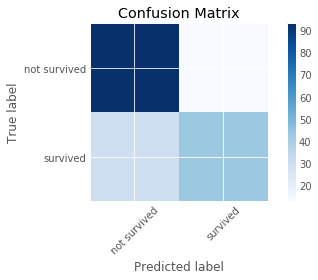

In [32]:
plot_confusion_matrix(cm)

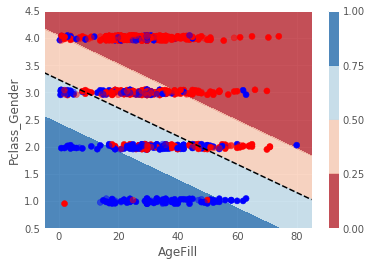

In [33]:
h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
levels = np.linspace(0, 1.0, 5)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
contour = ax.contourf(xx, yy, Z, cmap=cm, levels=levels, alpha=0.8)
#ax.scatter(X_train[:, 0], X_train[:, 1]+(np.random.rand(len(X_train))-0.5)*0.1, c=y_train, cmap=cm_bright)
#ax.scatter(X_val[:, 0], X_val[:, 1]+(np.random.rand(len(X_val))-0.5)*0.1, c=y_val, cmap=cm_bright, alpha=0.5)
ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1]+(np.random.rand(len(X_train))-0.5)*0.1, c=y_train, cmap=cm_bright)
ax.scatter(X_val.iloc[:, 0], X_val.iloc[:, 1]+(np.random.rand(len(X_val))-0.5)*0.1, c=y_val, cmap=cm_bright, alpha=0.5)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
fig.colorbar(contour)

x1 = xmin
x2 = xmax
y1 = -1*(clf.intercept_[0]+clf.coef_[0][0]*xmin)/clf.coef_[0][1]
y2 = -1*(clf.intercept_[0]+clf.coef_[0][0]*xmax)/clf.coef_[0][1]
ax.plot([x1, x2] ,[y1, y2], 'k--')

plt.show()

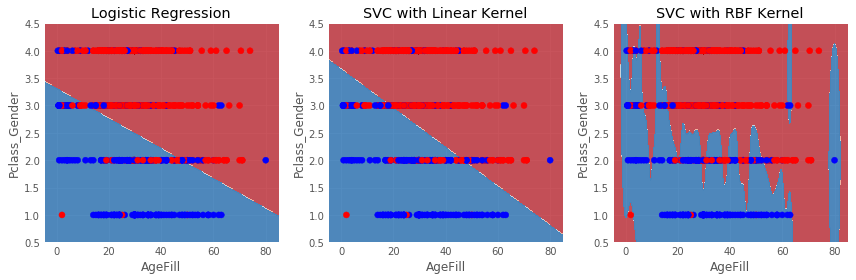

In [34]:
clf_log = LogisticRegression()
clf_svc_lin = SVC(kernel='linear', probability=True)
clf_svc_rbf = SVC(kernel='rbf', probability=True)
titles = ['Logistic Regression', 'SVC with Linear Kernel', 'SVC with RBF Kernel',]

h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))

fig, axes = plt.subplots(1, 3, figsize=(12,4))
levels = np.linspace(0, 1.0, 5)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
for i, clf in enumerate((clf_log, clf_svc_lin, clf_svc_rbf)):
    clf.fit(X, y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axes[i].contourf(xx, yy, Z, cmap=cm, levels=levels, alpha=0.8)
    axes[i].scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('AgeFill')
    axes[i].set_ylabel('Pclass_Gender')
    axes[i].set_xlim(xmin, xmax)
    axes[i].set_ylim(ymin, ymax)
    fig.tight_layout()

### 過学習（Overfitting）

In [35]:
clf = SVC(kernel='rbf', probability=True)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

print('Accuracy on Training Set: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Accuracy on Validation Set: {:.3f}'.format(accuracy_score(y_val, y_val_pred)))

Accuracy on Training Set: 0.826
Accuracy on Validation Set: 0.743


## 5. 交差検証（クロスバリデーション）
### 演習問題
モデルを評価するために、データを学習用と評価用の2つに分割することを説明しましたが、データが変わっても結果は同じでしょうか？train_test_splitで指定するrandom_stateの値を変化させて実際に確認してみましょう。
#### 解答例

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=33)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

print('Accuracy on Training Set: {:.3f}'.format(accuracy_score(y_train, y_train_pred)))
print('Accuracy on Test Set: {:.3f}'.format(accuracy_score(y_val, y_val_pred)))

Accuracy on Training Set: 0.784
Accuracy on Test Set: 0.743


In [37]:
def cross_val(clf, X, y, K, random_state=0):
    cv = KFold(len(y), K, shuffle=True, random_state=random_state)
    scores = cross_val_score(clf, X, y, cv=cv)
    return scores

In [38]:
clf = LogisticRegression()
scores = cross_val(clf, X, y, 5)
print('Scores:', scores)
print('Mean Score: {0:.3f} (+/-{1:.3f})'.format(scores.mean(), scores.std()*2))

TypeError: __init__() got multiple values for argument 'shuffle'

In [39]:
X = df_train[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']]
y = df_train['Survived']
X_test = df_test[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']]

In [40]:
X.tail()

,Age,Pclass,Sex,SibSp,Parch,Embarked
886,27.0,2,male,0,0,S
887,19.0,1,female,0,0,S
888,NaN,3,female,1,2,S
889,26.0,1,male,0,0,C
890,32.0,3,male,0,0,Q


In [41]:
X['AgeFill'] = X['Age'].fillna(X['Age'].mean())
X_test['AgeFill'] = X_test['Age'].fillna(X['Age'].mean())

X = X.drop(['Age'], axis=1)
X_test = X_test.drop(['Age'], axis=1)

In [42]:
le = LabelEncoder()
le.fit(X['Sex'])
X['Gender'] = le.transform(X['Sex'])
X_test['Gender'] = le.transform(X_test['Sex'])
classes = {gender: i for (i, gender) in enumerate(le.classes_)}
print(classes)

{'male': 1, 'female': 0}


In [43]:
X.tail()

,Pclass,Sex,SibSp,Parch,Embarked,AgeFill,Gender
886,2,male,0,0,S,27.000000,1
887,1,female,0,0,S,19.000000,0
888,3,female,1,2,S,29.699118,0
889,1,male,0,0,C,26.000000,1
890,3,male,0,0,Q,32.000000,1


In [44]:
X = X.join(pd.get_dummies(X['Embarked'], prefix='Embarked'))
X_test = X_test.join(pd.get_dummies(X['Embarked'], prefix='Embarked'))

In [45]:
X.tail()

,Pclass,Sex,SibSp,Parch,Embarked,AgeFill,Gender,Embarked_C,Embarked_Q,Embarked_S
886,2,male,0,0,S,27.000000,1,0,0,1
887,1,female,0,0,S,19.000000,0,0,0,1
888,3,female,1,2,S,29.699118,0,0,0,1
889,1,male,0,0,C,26.000000,1,1,0,0
890,3,male,0,0,Q,32.000000,1,0,1,0


In [46]:
X = X.drop(['Sex', 'Embarked'], axis=1)
X_test = X_test.drop(['Sex', 'Embarked'], axis=1)


In [47]:
clf = LogisticRegression()
scores = cross_val(clf, X, y, 5)
print('Scores:', scores)
print('Mean Score: {0:.3f} (+/-{1:.3f})'.format(scores.mean(), scores.std()*2))


TypeError: __init__() got multiple values for argument 'shuffle'

In [48]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=2)
scores = cross_val(clf, X, y, 5)
print('Scores:', scores)
print('Mean Score: {0:.3f} (+/-{1:.3f})'.format(scores.mean(), scores.std()*2))

TypeError: __init__() got multiple values for argument 'shuffle'

In [49]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=2)
scores = cross_val(clf, X, y, 5)
print('Scores:', scores)
print('Mean Score: {0:.3f} (+/-{1:.3f})'.format(scores.mean(), scores.std()*2))

TypeError: __init__() got multiple values for argument 'shuffle'

In [50]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=2)

param_grid = {'max_depth': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5]}
cv = KFold(len(y), 5, shuffle=True, random_state=0)

grid_search = GridSearchCV(clf, param_grid, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X, y)


TypeError: __init__() got multiple values for argument 'shuffle'